# Music prediction (JSB)

This tutorial builds on the basic understanding of OSTL. It applies OSTL to a multi-layered network, where only one layer consists of recurrent neurons. In particular, this tutorial covers:

1.	A demonstration of OSTL applied to more complex neural networks
2.	A demonstration of gradient equivalence between OSTL and BPTT for "hybrid" networks

## Musical notes as spikes

The presence of a particular sound at a particular time is what creates music. Alternatively, we can view the information about the presence of sounds or musical notes as spikes. A typical piano keyboard has 88 keys(https://commons.wikimedia.org/wiki/File:Piano_Keyboard_Diagram.svg). If each of those keys is individually represented as an input and the presence of a stroke of that key is represented as a 1 then one can encode a piece of music as a spiking input for neural networks. The animation below illustrates this process. 

![](./Figures/JSB_chords.gif)

Therefore, for each timestep of a musical piece, we can encode the information of the musical notes played by sending spikes to an input layer with 88 inputs. In this tutorial we use the JSB dataset from **N. Boulanger-Lewandowski, et al., ICML 2012**, that comprises chorales written by Johann Sebastian Bach.

## Implementation

We start by importing required Python packages and by defining an auxiliary function for data loading.

In [1]:
#General imports
import collections
import time
import pickle
import Scripts.Utils_Persistence as Utils_Persistence
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn_cell_impl

#Auxiliary function to load pkl file
def LoadObject(name):
    try:
        with open(name + '.pkl', 'rb') as f:
            object = pickle.load(f)
        return object
    except:
        return None

C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages

In [2]:
#OSTL specific inputs
from Scripts.RNN_loop import dynamic_rnn
from Scripts.MultiRNNCell import MultiRNNCell
from Scripts.gradient_descent import GradientDescentOptimizer as opt
from Scripts.Neuron_models import DenseRNNLayer, SNUELayer

### Define configuration of the network

In this section, the network configuration is defined. For example, the type of RNN units is selected.

In [3]:
config = {'batch_size': 1,
          'lr': 0.0005,              #Fixed learning rate used during training. 'lr': 0.0003 works well for LSTM
          'epochs': 100,             #Number of epochs to run
          'cell': 'sSNU',
          'N': [88,150,88],
          'save_state': True,
          #Specific arguments for the SNUs
          'args': {'recurrent': True, 'trainableDecay': False, 'activation': tf.nn.sigmoid, 'g': tf.identity, 'decay': 0.4}
          }

As the first step, we generate the data that will be used for training and testing.

In [4]:
#Fix the random seed in order to be able to numerically 
#compare the computed gradients
np.random.seed(1234)
tf.set_random_seed(1234)

#Load the JSB train dataset
train_xy = LoadObject('./Data/JSB_train')
len(train_xy)
train_xy[0].shape

#Load the JSB test dataset
test_xy = LoadObject('./Data/JSB_test')
len(test_xy)
test_xy[0].shape

(84, 88)

We can visualize the first 20 time steps of this chorales as spikes. Note that the most commonly used notes are in the center of the keyboard, e.g., from 40 to 65, and the y axis is cropped

In [5]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
from matplotlib import patches
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 22})

Text(0, 0.5, 'Key')

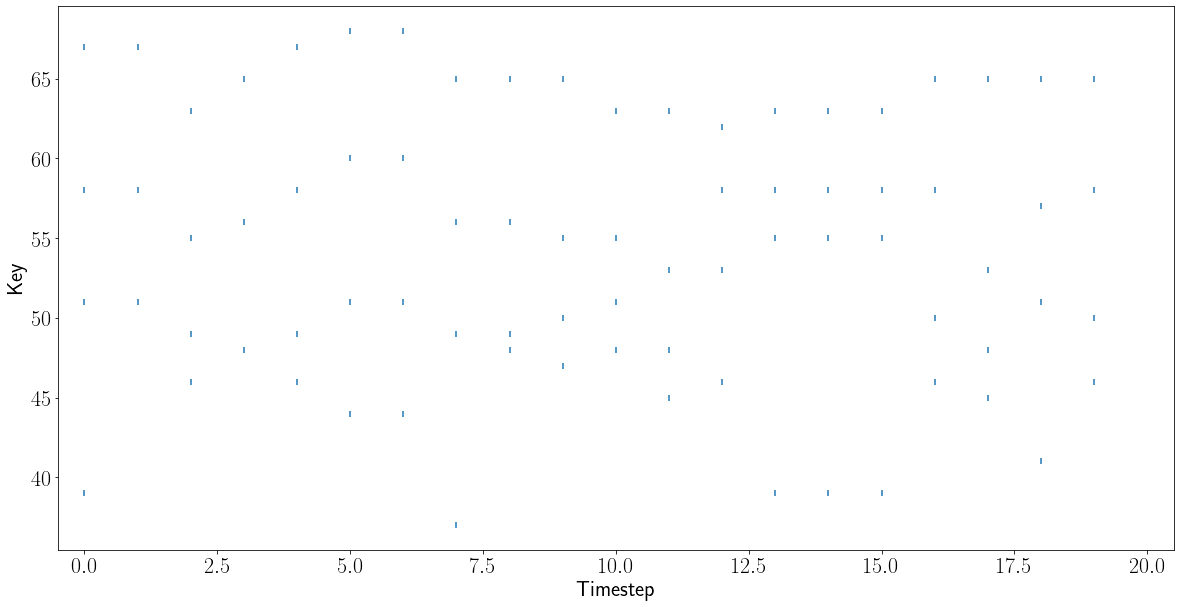

In [6]:
plt.scatter(*np.where(train_xy[0][0:20,:]), marker='|')
plt.xlabel('Timestep')
plt.xlim([-0.5,20.5])
plt.ylabel('Key')

### Preparation of the network architecture

Based on this encoding of the chorales, we can build a network that receives notes and outputs notes predicted for the next timestep. In such case, the last layer should also have 88 outputs, as illustrated below (Figure adapted from **[S.Woźniak, et al., 2020](https://www.nature.com/articles/s42256-020-0187-0)**, where more detailed explanations are provided):
![](./JSB_NW.svg)

Let's define some placeholders

In [7]:
#Define the placeholders to construct the network
x = tf.placeholder(tf.float32, [1, None, config['N'][0]]) #(batchsize, timesteps, number of units)
target = tf.placeholder(tf.float32, [1, None, config['N'][-1]])
train = tf.placeholder_with_default(tf.constant(1, tf.int32), ())

Let's define the units to be used. In this example we  use a single RNN layer and a sigmoid output layer on top. 
**[Can be removed]** As demonstrated in  **Supplementary material S4: OSTL applied to recurrent layers embedded in
stateless networks** of the paper **Bohnstingl, T., Woźniak, S., Maass, W., Pantazi, A., & Eleftheriou, E. (2020). Online Spatio-Temporal Learning in Deep Neural Networks. arXiv, 2007.12723. Retrieved from https://arxiv.org/abs/2007.12723v2**, any number of stateless layers at the output do not impede the gradient equivalence of OSTL and BPTT. Therefore, the results of OSTL and BPTT even for this network architecture are expected to be identical.

In [8]:
#List containing the RNN units
rnn_layers_BPTT = []
rnn_layers_OSTL = []

#Output variable that is used as the input to the different layers
out = x
for i in range(1,len(config['N'])-1):
    initW = np.random.uniform(-np.sqrt(6) / np.sqrt(config['N'][i-1] + config['N'][i]), np.sqrt(6) / np.sqrt(config['N'][i-1] + config['N'][i]), size=(config['N'][i-1], config['N'][i]))
    initH = np.random.uniform(-np.sqrt(6) / np.sqrt(config['N'][i] + config['N'][i]), np.sqrt(6) / np.sqrt(config['N'][i] + config['N'][i]), size=(config['N'][i], config['N'][i]))

    #Create the SNU layer for BPTT
    cell_BPTT = SNUELayer
    rnn_layers_BPTT.append(cell_BPTT(config['N'][i], config['N'][i-1], **config['args'], initW=initW, initH=initH, name='BPTT_RNN' + str(i)))

    #Create the SNU layer for OSTL
    cell_OSTL = SNUELayer
    rnn_layers_OSTL.append(cell_OSTL(config['N'][i], config['N'][i-1], **config['args'], initW=initW, initH=initH, name='OSTL_RNN' + str(i)))

#Create the output layer for BPTT and OSTL
initW = np.random.uniform(-np.sqrt(6) / np.sqrt(config['N'][-2] + config['N'][-1]), np.sqrt(6) / np.sqrt(config['N'][-2] + config['N'][-1]), size=(config['N'][-2], config['N'][-1]))
initB = np.zeros((config['N'][-1],))
rnn_layers_BPTT.append(DenseRNNLayer(units=config['N'][-1], num_units_prev=config['N'][-2], activation=None, initW=initW, initB=initB, name='BPTT_Dense'))
rnn_layers_OSTL.append(DenseRNNLayer(units=config['N'][-1], num_units_prev=config['N'][-2], activation=None, initW=initW, initB=initB, name='OSTL_Dense'))    

Define the optimizer to be used

In [9]:
optimizer = opt(learning_rate=config['lr'])

Next, we define the loss function and the optimization step

In [10]:
def loss_function(target_t, output_t, time, last_time):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_t, logits=output_t)
    return tf.reduce_sum(cross_entropy)

def gradient_function(loss, output_t, time, last_time, layer):
    grads = tf.gradients(loss, output_t)[0] #Eq (11) dE/dy: Only considers spatial components
    return grads

multi_rnn_cell_BPTT = tf.nn.rnn_cell.MultiRNNCell(rnn_layers_BPTT)
out_BPTT, _ = tf.nn.dynamic_rnn(multi_rnn_cell_BPTT, x, dtype=tf.float32)
loss_BPTT = loss_function(target, out_BPTT, None, 0)
train_step_BPTT = optimizer.minimize(loss_BPTT)

multi_rnn_cell_OSTL = MultiRNNCell(rnn_layers_OSTL)
out_OSTL, _ = dynamic_rnn(multi_rnn_cell_OSTL, x, target, loss_function, gradient_function, train, 1, 0, -1, optimizer, dtype=tf.float32)
loss_OSTL = loss_function(target, out_OSTL, None, 0)
train_step_OSTL = tf.no_op()

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Train the network

In [11]:
#Define a TF session
#with tf.Session() as s:
s = tf.Session()

#Run the initialization of the network
s.run(tf.global_variables_initializer())
  
#Define lists to store the loss values
avg_cost_list_BPTT = []
avg_cost_list_OSTL = []

#Try to load a checkpoint if any exists
resume = Utils_Persistence.LoadObject('./checkpoints/JSB_' + config['cell'])
if resume is not None:
    print('Loading checkpoint')
    epoch = resume['epoch']
    np.random.set_state(resume['rng'])
    Utils_Persistence.PersistenceLoadThis(s, 'JSB_' + config['cell'] + '_e' + str(epoch), withGraph=False)
    if epoch >= config['epochs']:
        print("State loaded: already finished training at epoch", epoch, ". Plotting & exiting.")
        exit(0)
    else:
        print('State loaded: resuming the learning from epoch', epoch)
    not_loaded = False
else:
    print("Did not find checkpoint. Run from scratch")
    epoch = 0
    not_loaded = True
    
epochs = config['epochs']

while epoch < epochs:
    epoch += 1;
    avg_cost_BPTT = 0
    avg_cost_OSTL = 0
    sum_len = 0
    avg_cost_test_BPTT = 0
    avg_cost_test_OSTL = 0
    sum_len_test = 0

    batch_size = config['batch_size']
    for b in range(0, len(train_xy), batch_size):
        batch_x = []
        batch_y = []
        inc = 0

        while(len(batch_x) < batch_size and (b + inc) <= len(train_xy)):
            batch_x.extend(train_xy[b+inc][0:-1, :])
            batch_y.extend(train_xy[b+inc][1:, :])
            inc += 1

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        if batch_size == 1:
            batch_x = np.expand_dims(batch_x, 0)

        if batch_size == 1:
            batch_y = np.expand_dims(batch_y, 0)

        [ce_BPTT, ce_OSTL, _, _] = s.run([loss_BPTT, loss_OSTL, train_step_BPTT, train_step_OSTL], 
                                 feed_dict={x: batch_x, target: batch_y, train: 1})
        avg_cost_BPTT += np.sum(ce_BPTT)
        avg_cost_OSTL += np.sum(ce_OSTL)
        sum_len += batch_x.shape[1]

    for b in range(0, len(test_xy), batch_size):
        batch_x = []
        batch_y = []
        inc = 0

        while(len(batch_x) < batch_size and (b + inc) <= len(test_xy)):
            batch_x.extend(test_xy[b+inc][0:-1, :])
            batch_y.extend(test_xy[b+inc][1:, :])
            inc += 1

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        if batch_size == 1:
            batch_x = np.expand_dims(batch_x, 0)

        if batch_size == 1:
            batch_y = np.expand_dims(batch_y, 0)

        [ce_BPTT, ce_OSTL] = s.run([loss_BPTT, loss_OSTL], feed_dict={x: batch_x, target: batch_y, train: 0})
        
        avg_cost_test_BPTT += np.sum(ce_BPTT)
        avg_cost_test_OSTL += np.sum(ce_OSTL)
        sum_len_test += batch_x.shape[1]
        
    avg_cost_list_BPTT.append(avg_cost_test_BPTT / sum_len_test)
    avg_cost_list_OSTL.append(avg_cost_test_OSTL / sum_len_test)
    
    print("BPTT -> Epoch:", epoch, "cost {:.4f}".format(avg_cost_BPTT / sum_len), "test cost {:.4f}".format(avg_cost_test_BPTT / sum_len_test))
    print("OSTL -> Epoch:", epoch, "cost {:.4f}".format(avg_cost_OSTL / sum_len), "test cost {:.4f}".format(avg_cost_test_OSTL / sum_len_test))
    
    
if not_loaded and config['save_state'] and ('JSB_' + config['cell']) is not None:
    Utils_Persistence.PersitenceSaveThis(s, 'JSB_' + config['cell'] + '_e' + str(epoch))
    Utils_Persistence.SaveObject({'epoch': epoch, 'rng': np.random.get_state(),
                                  'avg_cost_list_BPTT': avg_cost_list_BPTT, 
                                  'avg_cost_list_OSTL': avg_cost_list_OSTL}, './checkpoints/JSB_' + config['cell'])
    print('State saved at epoch ' + str(epoch))

Loading checkpoint
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints/JSB_sSNU_e100
State loaded: already finished training at epoch 100 . Plotting & exiting.


### Evaluate the network

Load stored checkpoints

In [12]:
#Try to load a checkpoint if any exists
resume = Utils_Persistence.LoadObject('./checkpoints/JSB_' + config['cell'])
if resume is not None:
    print('Loading checkpoint')
    epoch = resume['epoch']
    avg_cost_list_BPTT = resume['avg_cost_list_BPTT']
    avg_cost_list_OSTL = resume['avg_cost_list_OSTL']
    np.random.set_state(resume['rng'])
    Utils_Persistence.PersistenceLoadThis(s, 'JSB_' + config['cell'] + '_e' + str(epoch), withGraph=False)
    print('State loaded: resuming the learning from epoch', epoch)
else:
    print("Did not find checkpoint. Please run model from scratch!")

Loading checkpoint
INFO:tensorflow:Restoring parameters from ./checkpoints/JSB_sSNU_e100
State loaded: resuming the learning from epoch 100


### Investigate the gradients

Finally, we can plot the loss function as a proxy of the equivalent gradients:

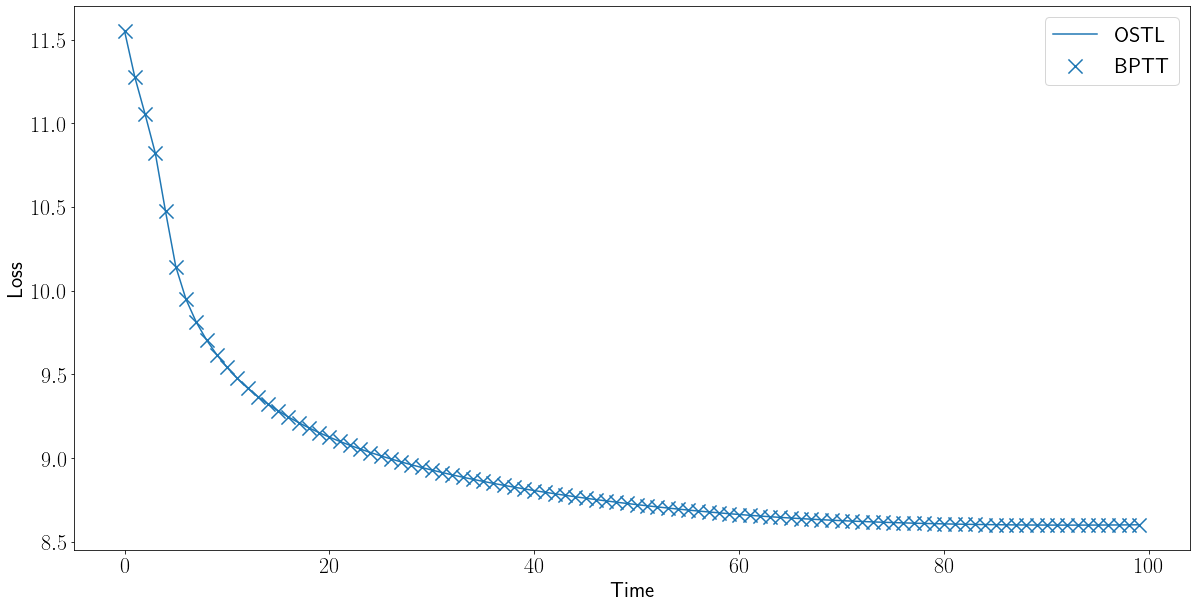

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(avg_cost_list_BPTT, label='OSTL')
ax.scatter(np.arange(len(avg_cost_list_BPTT)), avg_cost_list_BPTT, marker='x', s=200, label='BPTT')
ax.set_xlabel('Time')
ax.set_ylabel('Loss')
ax.legend()